[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Skier Ranking using Depth-Aware Tracking**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

This notebook implements an advanced computer vision pipeline designed to detect, track, and rank skiers in a video. Unlike traditional 2D ranking systems that assume "lower in image = closer," this project utilizes **Monocular Depth Estimation** to determine the true relative distance of each skier from the camera, ensuring accurate ranking regardless of camera angle or slope curvature.

## **Core Idea: *Depth vs. Position***
Standard position-based ranking methods usually rank objects based on their Y-coordinate (vertical position). This fails on ski slopes where the path might curve or the camera angle changes.
*   **The Solution:** We generate a "depth map" for every frame, determining how far away every pixel is. By calculating the median depth value of each detected skier, we can accurately rank them (1st is closest, last is furthest) in 3D space using only a 2D video.

## **Workflow**

### 1. Data Preparation
*   **Frame Extraction:** Converts detected video segments into individual frames for dataset creation.
*   **Format Conversion:** Converts annotations from COCO JSON format to YOLO format to prepare for model training.

### 2. Model Detection (RT-DETR)
*   **Architecture:** Uses **RT-DETR (Real-Time Detection Transformer)**, a modern anchor-free object detector that balances speed and accuracy.
*   **Training:** Fine-tunes the model specifically on skier datasets to reliably detect skiers even in motion or varying poses.

### 3. Intelligent Tracking & Ranking (The Engine)
*   **Depth Estimation:** Utilizes the **Depth Anything V2** model to create high-quality depth maps from standard RGB images.
*   **Focus Region:** Allows defining a specific polygon (region of interest) on the ski slope to ignore spectators or irrelevant objects.
*   **Ranking Logic:**
    1.  Detect skiers in the current frame.
    2.  Track identities using **ByteTrack**.
    3.  Compute the median depth within each skier's bounding box.
    4.  Sort skiers by depth: **Lower Depth Value = Closer to Camera = Higher Rank.**

### 4. Visualization
*   **Rank Indicators:** Draws distinct, colored triangles above each skier indicating their current rank.
*   **Motion Trails:** Renders fading historical paths to visualize movement patterns.
*   **Leaderboard:** Displays a real-time list of skier rankings and IDs.

## Import Libraries
Import necessary libraries for computer vision, visualization, and deep learning.

In [ ]:
# !pip install ultralytics opencv-python transformers pillow numpy tqdm
# !git clone https://github.com/Labellerr/yolo_finetune_utils.git

In [22]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, pipeline
from ultralytics import RTDETR
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Optional, List
from pathlib import Path
import random
from PIL import Image
from __future__ import annotations
from tqdm import tqdm
%matplotlib inline

## Extract Frames
Extract frames from video for dataset creation.

In [ ]:
from yolo_finetune_utils.frame_extractor import extract_random_frames

extract_random_frames(
        paths=[r"video/skiing_1"],
        total_images=30,
        out_dir="dataset_frames",
        jpg_quality=100,
        seed=42
    )

## Convert Annotations to Model Training Format
Convert COCO JSON annotations to YOLO format for segmentation.

In [ ]:
from yolo_finetune_utils.coco_yolo_converter.seg_converter import coco_to_yolo_converter

ANNOTATION_JSON = "annotations.json"
IMAGE_DIR = "dataset_frames"


coco_to_yolo_converter(
        json_path=ANNOTATION_JSON,
        images_dir=IMAGE_DIR,
        output_dir="model_dataset",
        use_split=True,
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
        shuffle=True,
        verbose=False
    )

## System Check: GPU Memory Status
Clear GPU cache and display current memory usage to ensure sufficient resources for training.
**Memory Metrics**:
- **Allocated**: Currently used GPU memory
- **Cached**: Reserved but not actively used
- **Free**: Available GPU memory
> Run this cell before training to free up GPU memory.

In [2]:
torch.cuda.empty_cache()

# Check GPU memory status
print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"Cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
print(f"Free: {torch.cuda.mem_get_info(0)[0]/1024**3:.2f} GB")

Allocated: 0.00 GB
Cached: 0.00 GB
Free: 6.87 GB


## Model Training: RT-DETR for Detection
Train the RT-DETR-L (Large) model on the dataset.
**Training Configuration**:
| Parameter | Value | Description |
|-----------|-------|-------------|
| `data` | `model_dataset/data.yaml` | Dataset configuration file |
| `epochs` | 200 | Number of training epochs |
| `imgsz` | 640 | Input image size (640x640) |
| `batch` | 4 | Batch size |
| `device` | 0 | GPU device ID (0 = first GPU) |
| `workers` | 1 | Number of dataloader workers |
**Model**: RT-DETR-L (Large variant)
- Pre-trained weights: `rtdetr-x.pt`
- Architecture: Real-Time Detection Transformer
- Optimized for real-time object detection
> **Training Time**: Approximately 30-60 minutes depending on GPU

In [ ]:
# Load a model
model = RTDETR("rtdetr-x.pt")

# Train the model
results = model.train(
    data=r"model_dataset\data.yaml",    # Path to your dataset YAML file
    epochs=200,                        # Number of training epochs
    imgsz=640,                         # Image size
    batch=4,                          # Batch size
    device=0,                          # GPU device (0 for first GPU, 'cpu' for CPU)
    workers=1                          # Number of dataloader workers
)

## Visualize the model inference on a frame



image 1/1 d:\Professional\Projects\Depth_Aware_Object_Ranking\video\skiing_1_frame_000013_t0.43s_000001.jpg: 640x640 12 Skiers, 37.3ms
Speed: 6.0ms preprocess, 37.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


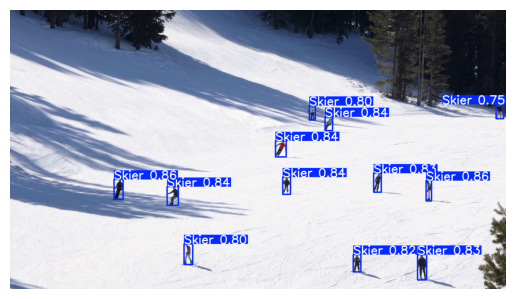

Detected 12 skiers
Skier 1: Confidence = 0.86
Skier 2: Confidence = 0.86
Skier 3: Confidence = 0.84
Skier 4: Confidence = 0.84
Skier 5: Confidence = 0.84
Skier 6: Confidence = 0.84
Skier 7: Confidence = 0.83
Skier 8: Confidence = 0.83
Skier 9: Confidence = 0.82
Skier 10: Confidence = 0.80
Skier 11: Confidence = 0.80
Skier 12: Confidence = 0.75


In [3]:
# Load your trained model
model = RTDETR(r"runs\detect\train\weights\best.pt")

# Test on your image
image_path = r'video\skiing_1_frame_000013_t0.43s_000001.jpg'
results = model(image_path, conf=0.5)

# Visualize detections in notebook
img = results[0].plot()
plt.imshow(img[:, :, ::-1]) # Convert BGR to RGB
plt.axis('off')
plt.show()

# Save detections
# results[0].save('detected_skiers.jpg')

# Check detection quality
print(f"Detected {len(results[0].boxes)} skiers")
for i, box in enumerate(results[0].boxes):
    conf = box.conf[0]
    print(f"Skier {i+1}: Confidence = {conf:.2f}")

## Inference: Track objects in Video
Run the trained RT-DETR model on a sample video to detect and track objects.
**Inference Configuration**:
- **Model**: Best weights from training (`runs/detect/train/weights/best.pt`)
- **Confidence Threshold**: 0.8 (80%)
- **Tracking**: Enabled with `track()` method
- **Labels**: Hidden (`show_labels=False`)
**Output**: 
- Tracked video saved to `runs/detect/track*/`
- Each frame shows detected objects with bounding boxes
- Real-time inference speed displayed per frame

In [ ]:
model = RTDETR(r"runs\detect\train\weights\best.pt")

video_path = r"video\skiing_1.mp4"

results = model.track(video_path, persist= True, save= True, show_labels= False, conf= 0.5, stream= True)

for result in results:
    pass

## Helper: Extract and Display Frame
Define a function to extract and display a specific frame from a video.

In [5]:
def extract_nth_frame(video_path, frame_number):
    """
    Extract the nth frame from a video and display it using matplotlib.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_number : int
        The frame number to extract (0-indexed)
    
    Returns:
    --------
    frame : numpy.ndarray
        The extracted frame in RGB format, or None if extraction fails
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None
    
    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Check if the requested frame number is valid
    if frame_number < 0 or frame_number >= total_frames:
        print(f"Error: Frame number {frame_number} is out of range (0-{total_frames-1})")
        cap.release()
        return None
    
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        cap.release()
        return None
    
    # Release the video capture object
    cap.release()
    
    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## Visualize Frames of video
Extract and display specific frames to check the video content.

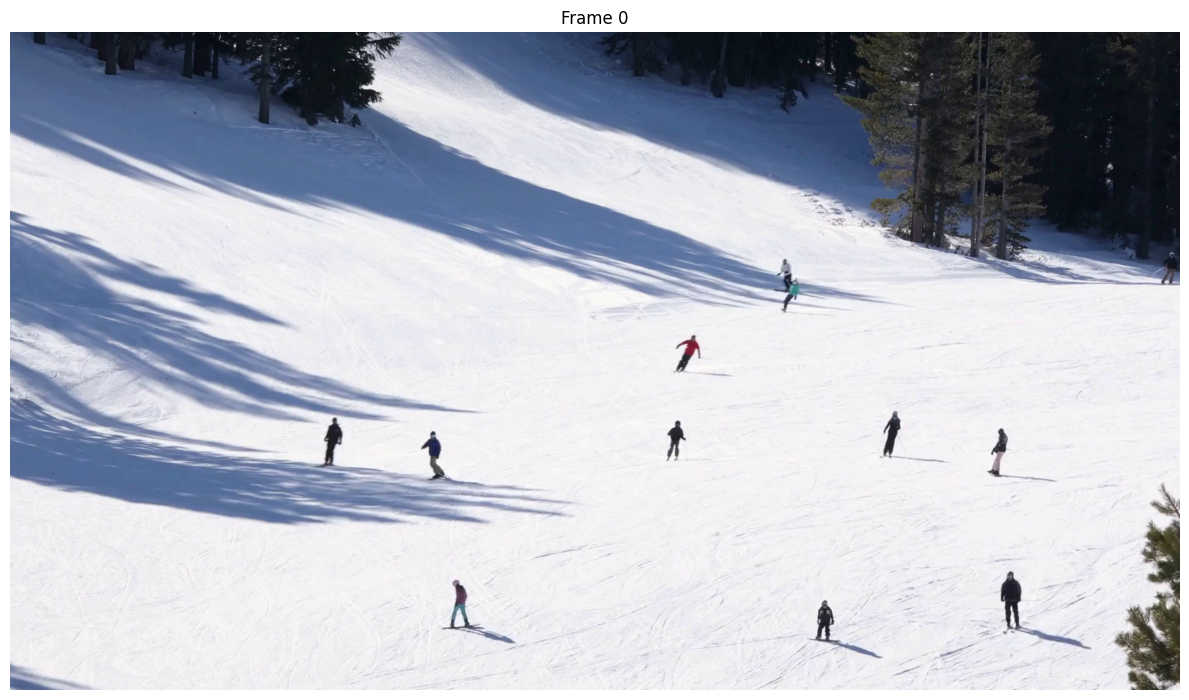

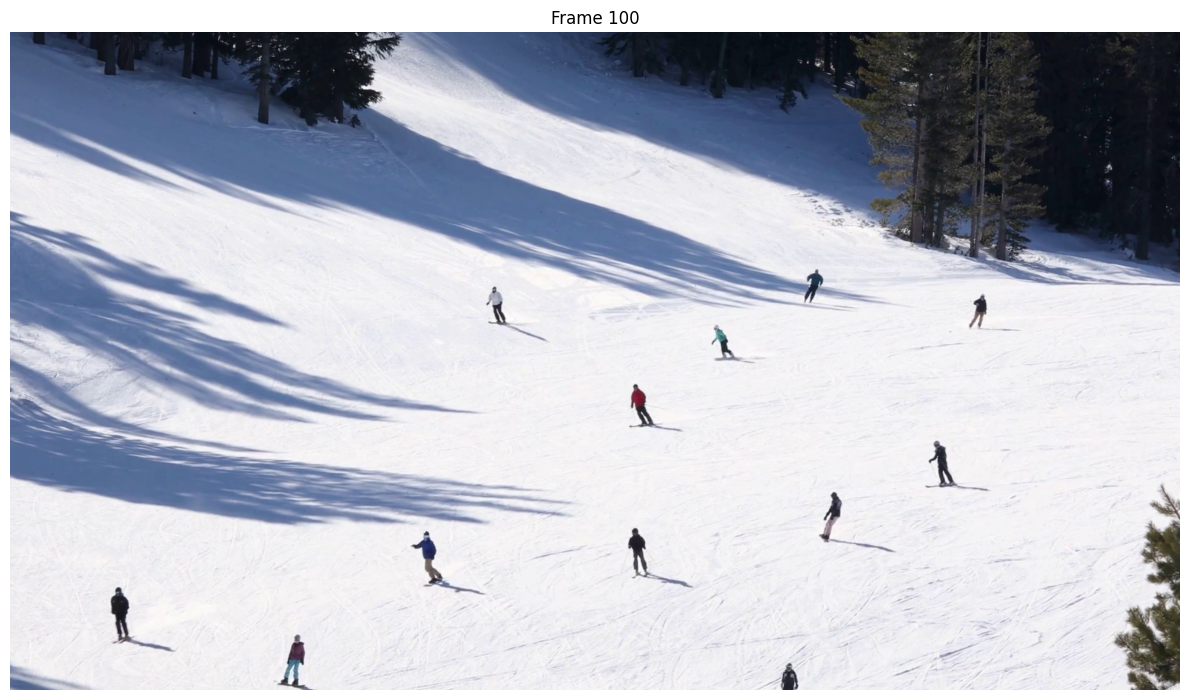

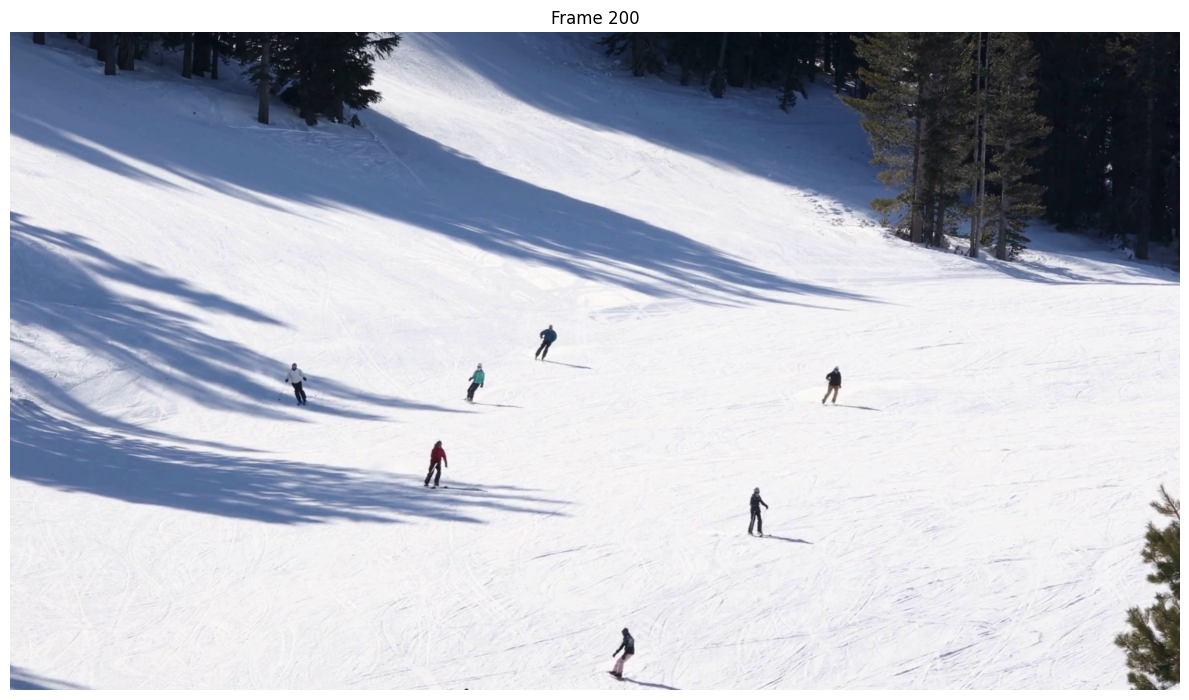

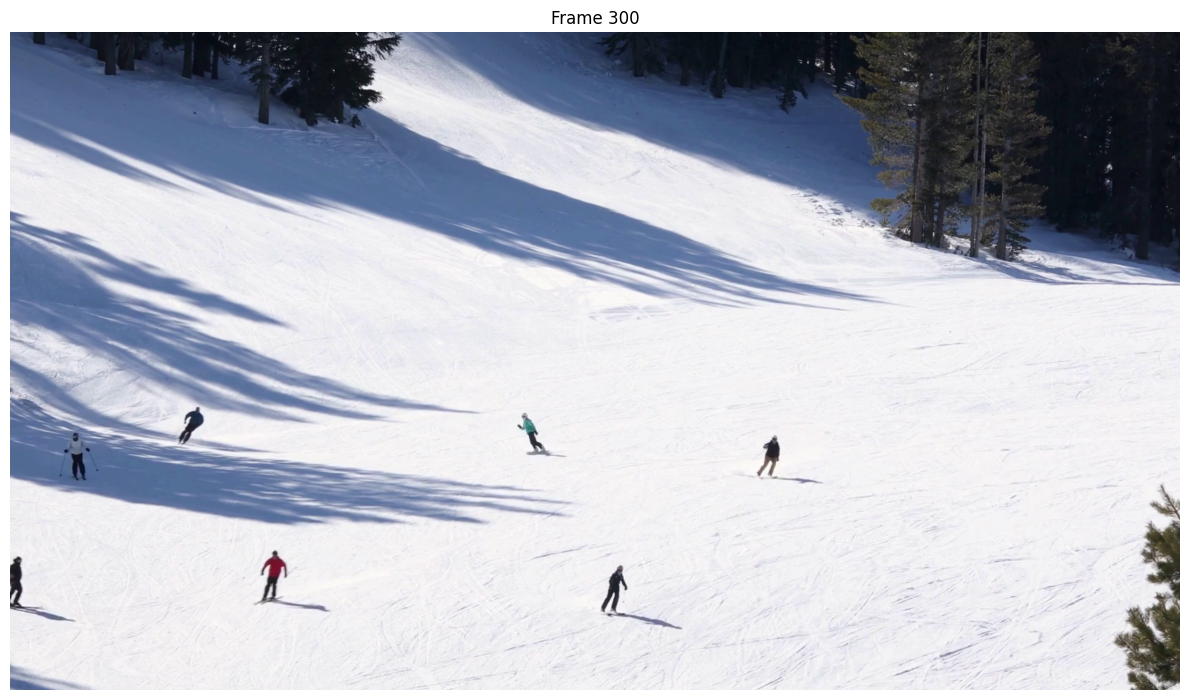

In [6]:
video_path = r"video\skiing_1.mp4"

frame_no = [0, 100, 200, 300]

for frame in frame_no:
    extract_nth_frame(video_path, frame)

## Helper: Interactive ROI Selector
Define a function to interactively draw a polygon ROI on a video frame.

In [17]:
def get_polygon_points(video_path, frame_no=0):
    """
    Draw a polygon on a video frame using OpenCV interactive UI.
    
    Controls:
    - Left-click: Add point to polygon
    - Right-click: Finish polygon (minimum 3 points)
    - Press 'r': Reset and start over
    - Press 'c': Complete polygon (same as right-click)
    - Press 'Esc': Cancel and exit
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_no : int
        Frame number to extract (default: 0)
    
    Returns:
    --------
    list : List of polygon points [(x1, y1), (x2, y2), ...]
           Returns None if drawing failed or cancelled
    
    Example:
    --------
    >>> polygon = get_polygon_points("video.mp4", frame_no=100)
    >>> print(polygon)
    [(100, 200), (300, 200), (300, 400), (100, 400)]
    """
    
    # Extract frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"❌ Error: Could not read frame {frame_no}")
        return None
    
    # State variables
    points = []
    drawing_complete = False
    frame_copy = frame.copy()
    
    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal points, drawing_complete
        
        # Left click - add point
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"✓ Point {len(points)}: ({x}, {y})")
        
        # Right click - finish polygon
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
    
    # Create window
    window_name = "Draw Polygon Perimeter"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    # Print instructions
    print("\n" + "="*70)
    print("POLYGON DRAWING - INTERACTIVE UI")
    print("="*70)
    print("  Left-click:  Add point to polygon")
    print("  Right-click: Finish polygon (minimum 3 points)")
    print("  Press 'r':   Reset and start over")
    print("  Press 'c':   Complete polygon")
    print("  Press 'Esc': Cancel and exit")
    print("="*70 + "\n")
    
    while True:
        # Create display frame
        display_frame = frame_copy.copy()
        
        # Draw all points
        for i, point in enumerate(points):
            # Draw point
            cv2.circle(display_frame, point, 6, (0, 255, 0), -1)
            cv2.circle(display_frame, point, 8, (255, 255, 255), 2)
            
            # Add point number
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        
        # Draw lines between consecutive points
        if len(points) > 1:
            for i in range(len(points) - 1):
                cv2.line(display_frame, points[i], points[i+1], (0, 255, 0), 2)
        
        # Draw closing line and fill if polygon is complete or has 3+ points
        if len(points) >= 3:
            # Draw closing line
            cv2.line(display_frame, points[-1], points[0], (0, 255, 0), 2)
            
            # Fill polygon with semi-transparent overlay
            overlay = display_frame.copy()
            pts = np.array(points, dtype=np.int32)
            cv2.fillPoly(overlay, [pts], (0, 255, 0))
            cv2.addWeighted(overlay, 0.3, display_frame, 0.7, 0, display_frame)
        
        # Add status text at the top
        status_text = f"Points: {len(points)}"
        if drawing_complete:
            status_text = f"COMPLETE - {len(points)} points (Press any key to exit)"
            cv2.rectangle(display_frame, (5, 5), (750, 45), (0, 200, 0), -1)
        else:
            cv2.rectangle(display_frame, (5, 5), (600, 45), (0, 0, 0), -1)
        
        cv2.putText(display_frame, status_text, (15, 32),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        
        # Show frame
        cv2.imshow(window_name, display_frame)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        # Esc - cancel
        if key == 27:
            print("❌ Cancelled by user")
            cv2.destroyAllWindows()
            return None
        
        # 'r' - reset
        elif key == ord('r') or key == ord('R'):
            points = []
            drawing_complete = False
            print("🔄 Reset - draw a new polygon")
        
        # 'c' - complete
        elif key == ord('c') or key == ord('C'):
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
        
        # Exit if drawing is complete
        if drawing_complete:
            cv2.waitKey(1500)  # Show final result for 1.5 seconds
            break
    
    cv2.destroyAllWindows()
    
    if len(points) < 3:
        print(f"⚠ No valid polygon drawn (need at least 3 points)")
        return None
    
    print(f"\n✅ Polygon saved with {len(points)} vertices")
    print(f"Coordinates: {points}\n")
    return points


## Define Region of Interest
Launch the interactive tool to define the polygon ROI on a selected frame.

In [18]:
perimeter_polygon = get_polygon_points(video_path, 50)


POLYGON DRAWING - INTERACTIVE UI
  Left-click:  Add point to polygon
  Right-click: Finish polygon (minimum 3 points)
  Press 'r':   Reset and start over
  Press 'c':   Complete polygon
  Press 'Esc': Cancel and exit

✓ Point 1: (15, 571)
✓ Point 2: (3532, 712)
✓ Point 3: (3612, 2145)
✓ Point 4: (28, 2148)
✓ Polygon complete: 4 points

✅ Polygon saved with 4 vertices
Coordinates: [(15, 571), (3532, 712), (3612, 2145), (28, 2148)]



## Helper: Annotate ROI
Define a function to verify the selected ROI by overlaying it on the frame.

In [15]:
def annotate_frame_with_polygon(video_path, frame_number, polygon_coords):
    """
    Annotate a specific video frame with a polygon region.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file.
    frame_number : int
        The frame number to extract and annotate.
    polygon_coords : list
        List of (x, y) tuples defining the polygon vertices.
        Example: [(2, 2150), (1262, 1348), (3838, 1402), (3838, 2155), (15, 2158)]
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        return
    # Create a copy for drawing
    annotated_frame = frame.copy()
    
    # Convert polygon coordinates to numpy array
    pts = np.array(polygon_coords, np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # Draw polygon: Magenta color, thickness 5
    cv2.polylines(annotated_frame, [pts], isClosed=True, color=(255, 0, 255), thickness=5)
    
    # Optional: Fill polygon with semi-transparent overlay
    overlay = annotated_frame.copy()
    cv2.fillPoly(overlay, [pts], (255, 0, 255))
    cv2.addWeighted(overlay, 0.2, annotated_frame, 0.8, 0, annotated_frame)
    # Convert to RGB for matplotlib display
    frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_number} with ROI")
    plt.axis('off')
    plt.show()

## Verify ROI Annotation
Display the frame with the defined polygon overlay to verify accuracy.

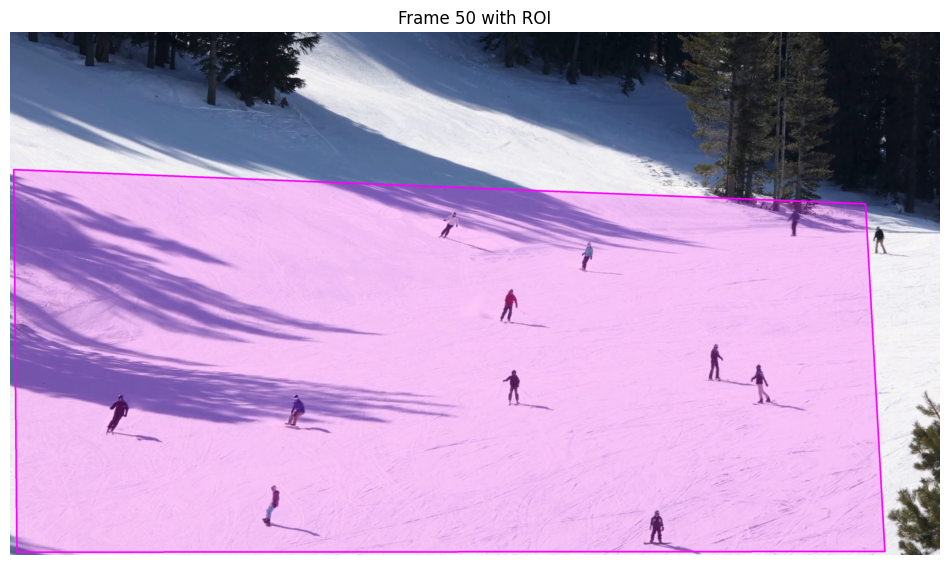

In [19]:
perimeter_polygon = [(15, 571), (3532, 712), (3612, 2145), (28, 2148)]
annotate_frame_with_polygon(video_path, 50, perimeter_polygon)

In [20]:
def depth_estimate(image_path, crop_vertices=None, model_id="depth-anything/Depth-Anything-V2-Large-hf", device="cuda"):
    # Load model once (cache globally for reuse)
    if not hasattr(depth_estimate, "processor"):
        depth_estimate.processor = AutoImageProcessor.from_pretrained(model_id)
        depth_estimate.model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device)
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    orig_image = np.array(image)
    
    # Handle crop with perspective transform if vertices provided
    if crop_vertices:
        # Convert to numpy array format for cv2
        pts_src = np.array(crop_vertices, dtype=np.float32)
        
        # Compute width and height of the output rectangle
        width = int(max(
            np.linalg.norm(pts_src[1] - pts_src[0]),
            np.linalg.norm(pts_src[2] - pts_src[3])
        ))
        height = int(max(
            np.linalg.norm(pts_src[3] - pts_src[0]),
            np.linalg.norm(pts_src[2] - pts_src[1])
        ))
        
        # Destination points for the cropped rectangle
        pts_dst = np.array([
            [0, 0],
            [width, 0],
            [width, height],
            [0, height]
        ], dtype=np.float32)
        
        # Perspective transform
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        cropped = cv2.warpPerspective(orig_image, matrix, (width, height))
        process_img = Image.fromarray(cropped)
        
        # Store for visualization
        crop_info = (orig_image, pts_src, matrix)
    else:
        process_img = image
        crop_info = None
    
    # Process image
    inputs = depth_estimate.processor(images=process_img, return_tensors="pt").to(device)
    
    # Inference
    with torch.no_grad():
        output = torch.nn.functional.interpolate(
            depth_estimate.model(**inputs).predicted_depth.unsqueeze(1),
            size=process_img.size[::-1],
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()
    
    # Visualization
    fig, axes = plt.subplots(1, 3 if crop_vertices else 2, figsize=(16 if crop_vertices else 12, 5))
    if not crop_vertices:
        axes = [axes[0], None, axes[1]]
    
    # Original with crop overlay
    axes[0].imshow(orig_image)
    if crop_vertices:
        pts = np.array(crop_vertices + [crop_vertices[0]])
        axes[0].plot(pts[:, 0], pts[:, 1], 'r-', linewidth=2)
        axes[0].set_title("Original (Crop Region)")
    else:
        axes[0].set_title("Original")
    axes[0].axis("off")
    
    # Cropped region
    if crop_vertices:
        axes[1].imshow(process_img)
        axes[1].set_title("Cropped Region")
        axes[1].axis("off")
    
    # Depth map
    im = axes[2].imshow(output, cmap="magma")
    axes[2].set_title("Depth Map")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046)
    
    plt.tight_layout()
    plt.show()



Loading weights: 100%|██████████| 503/503 [00:00<00:00, 912.81it/s, Materializing param=neck.reassemble_stage.layers.3.resize.weight]                  


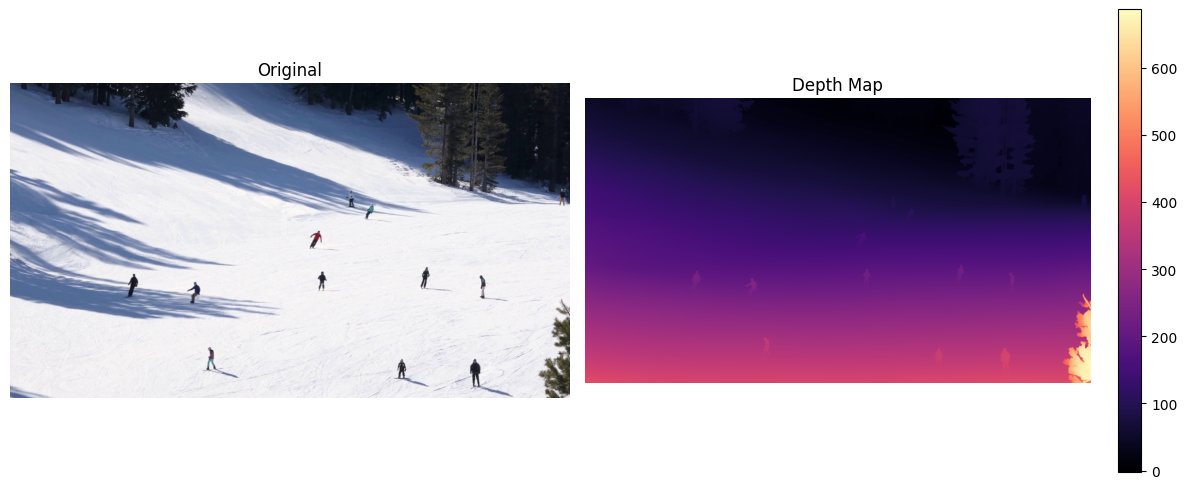

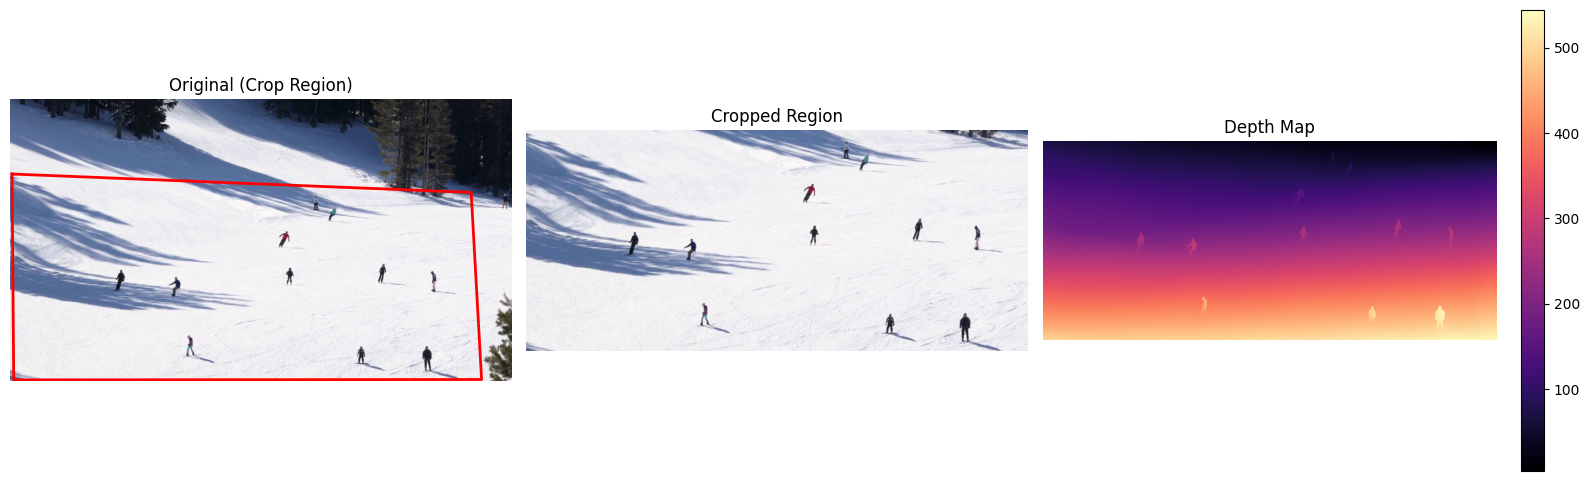

In [21]:
# Usage examples:
image_path = r'video\skiing_1_frame_000013_t0.43s_000001.jpg'

depth_estimate(image_path)  # Full frame
depth_estimate(image_path, crop_vertices=[(15, 571), (3532, 712), (3612, 2145), (28, 2148)])


## SkierRanker Class using RT-DETR and Depth Anything
Ranks detected skiers by depth or position in images/videos.

    This class combines object detection (RT-DETR) with monocular depth estimation
    (Depth Anything) to determine the spatial ordering of detected skiers. It supports
    both single image processing and video processing with object tracking.

    Features:
        - Unique color assignment per tracked object
        - Path trails showing movement history (configurable length)
        - Mini depth map overlay for visualization
        - Two ranking methods: depth-based (accurate) and position-based (fast)

In [23]:
class SkierRanker:
    """
    Args:
        model_path: Path to trained RT-DETR model weights.
        depth_model: HuggingFace model ID for depth estimation.
        device: Device for inference ('cuda:0', 'cuda', or 'cpu').
        conf_threshold: Detection confidence threshold (0.0 to 1.0).
        trail_length: Number of frames to keep for path trails.
        max_depth_size: Maximum image size (longest edge) for depth estimation.
            Larger images will be resized to avoid memory issues. Default: 1024.

    """

    def __init__(
        self,
        model_path: str = "runs/detect/train/weights/best.pt",
        depth_model: str = "depth-anything/Depth-Anything-V2-Large-hf",
        device: str = "cuda:0",
        conf_threshold: float = 0.5,
        trail_length: int = 60,
        max_depth_size: int = 1024,
        nms_threshold: float = 0.3,
    ) -> None:
        """Initialize the SkierRanker with detection and depth models."""
        self.device = device
        self.conf_threshold = conf_threshold
        self.trail_length = trail_length
        self.nms_threshold = nms_threshold
        self.max_depth_size = max_depth_size

        # Focus polygon for depth estimation (region of interest)
        # Default polygon for ski slope: [(15, 322), (1810, 358), (1811, 1076), (9, 1078)]
        self.focus_polygon: list[tuple[int, int]] | None = None

        # Load detection model
        print(f"[INFO] Loading detection model from: {model_path}")
        self.model = RTDETR(model_path)

        # Load depth estimation model
        print(f"[INFO] Loading depth model: {depth_model}")
        self.depth_estimator = pipeline(
            "depth-estimation",
            model=depth_model,
            device=device if device != "cpu" else -1,
        )

        # Track history for path trails: {track_id: [(x, y), ...]}
        self.track_history: dict[int, list[tuple[int, int]]] = {}

        # Finished objects: {track_id: {"rank": int, "color": tuple, "finish_order": int}}
        self.finished_objects: dict[int, dict] = {}
        self.finish_counter = 0  # Order in which objects finish

        # Track last known positions to detect bottom-passing
        self.last_positions: dict[int, tuple[int, int, int, int]] = {}  # {track_id: bbox}

        # Valid track IDs (entered from top or present in first frames)
        self.valid_track_ids: set[int] = set()
        self.frame_count = 0  # Track frame number for initial grace period

        print("[INFO] Models loaded successfully!")

    def set_focus_polygon(self, polygon: list[tuple[int, int]]) -> None:
        """
        Set the polygon region for focused depth estimation.

        Only the area inside this polygon will be used for depth analysis.
        This helps ignore irrelevant areas like sky, trees, or UI elements.

        Args:
            polygon: List of (x, y) vertex coordinates defining the ROI.
        """
        self.focus_polygon = polygon
        print(f"[INFO] Focus polygon set with {len(polygon)} vertices")

    def _create_polygon_mask(self, shape: tuple, polygon: list[tuple[int, int]]) -> np.ndarray:
        """
        Create a binary mask from polygon vertices.

        Args:
            shape: (height, width) of the mask.
            polygon: List of (x, y) vertex coordinates.

        Returns:
            Binary mask with 1 inside polygon, 0 outside.
        """
        mask = np.zeros(shape[:2], dtype=np.uint8)
        pts = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 1)
        return mask

    def _calculate_iou(self, box1: tuple, box2: tuple) -> float:
        """
        Calculate Intersection over Union between two bounding boxes.

        Args:
            box1: Bounding box as (x1, y1, x2, y2).
            box2: Bounding box as (x1, y1, x2, y2).

        Returns:
            IoU value between 0 and 1.
        """
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0

    def _filter_duplicate_detections(self, skiers: list[dict]) -> list[dict]:
        """
        Filter duplicate detections that overlap significantly.

        Keeps the detection with higher confidence when two detections
        have IoU above the threshold.

        Args:
            skiers: List of skier dictionaries from extract_skier_data.

        Returns:
            Filtered list with duplicate detections removed.
        """
        if len(skiers) <= 1:
            return skiers

        # Sort by confidence (highest first)
        sorted_skiers = sorted(skiers, key=lambda s: s["confidence"], reverse=True)
        keep = []

        for skier in sorted_skiers:
            is_duplicate = False
            for kept in keep:
                iou = self._calculate_iou(skier["bbox"], kept["bbox"])
                if iou > self.nms_threshold:
                    is_duplicate = True
                    break
            if not is_duplicate:
                keep.append(skier)

        return keep

    def _filter_invalid_new_ids(
        self,
        skiers: list[dict],
        frame_height: int,
        top_threshold: float = 0.25,
        initial_frames: int = 30,
    ) -> list[dict]:
        """
        Filter out new track IDs that don't enter from the top of the frame.

        Only accepts new track IDs if:
        1. They are in the first N frames (initial_frames), OR
        2. Their bounding box top (y1) is within the top portion of the frame

        This prevents mid-frame ID reassignment when tracking is lost.

        Args:
            skiers: List of skier dictionaries with track_id.
            frame_height: Height of the video frame.
            top_threshold: Fraction of frame height considered as "top" (0.25 = top 25%).
            initial_frames: Number of initial frames where all IDs are accepted.

        Returns:
            Filtered list with only valid track IDs.
        """
        valid_skiers = []

        for skier in skiers:
            track_id = skier.get("track_id")
            if track_id is None:
                continue

            # If already known as valid, keep it
            if track_id in self.valid_track_ids:
                valid_skiers.append(skier)
                continue

            # Check if this is a new track ID
            x1, y1, x2, y2 = skier["bbox"]

            # Accept all IDs in initial frames
            if self.frame_count < initial_frames:
                self.valid_track_ids.add(track_id)
                valid_skiers.append(skier)
            # Accept new IDs only if they enter from the top
            elif y1 <= frame_height * top_threshold:
                self.valid_track_ids.add(track_id)
                valid_skiers.append(skier)
            # Reject new IDs that appear mid-frame (likely re-assigned ID)
            else:
                # Skip this detection - it's a spurious new ID
                pass

        return valid_skiers

    def _get_color_for_id(self, track_id: int) -> tuple[int, int, int]:
        """
        Generate a unique, visually distinct BGR color for a track ID.

        Uses golden ratio hue spacing to ensure maximum color separation
        between consecutive track IDs.

        Args:
            track_id: The tracking ID to generate color for.

        Returns:
            BGR color tuple (B, G, R) with values 0-255.
        """
        golden_ratio = 0.618033988749895
        hue = (track_id * golden_ratio) % 1.0

        # Convert HSV to BGR (OpenCV format)
        # High saturation and value for vivid colors``
        hsv = np.array([[[int(hue * 180), 255, 255]]], dtype=np.uint8)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        b, g, r = int(bgr[0, 0, 0]), int(bgr[0, 0, 1]), int(bgr[0, 0, 2])
        return (b, g, r)

    def _update_track_history(self, skiers: list[dict]) -> None:
        """
        Update path history for each tracked object.

        Maintains a sliding window of center positions for each track ID,
        limited to `trail_length` most recent positions.

        Args:
            skiers: List of skier dictionaries with 'track_id' and 'center' keys.
        """
        for skier in skiers:
            track_id = skier.get("track_id")
            if track_id is None:
                continue

            center = skier["center"]

            if track_id not in self.track_history:
                self.track_history[track_id] = []

            self.track_history[track_id].append(center)

            # Keep only the most recent positions
            if len(self.track_history[track_id]) > self.trail_length:
                self.track_history[track_id].pop(0)

    def _detect_finished_objects(
        self,
        current_skiers: list[dict],
        frame_height: int,
        bottom_threshold: float = 0.95,
    ) -> None:
        """
        Detect objects that have passed the bottom of the frame.

        An object is considered "finished" when:
        1. It was visible in the previous frame (in last_positions)
        2. It is no longer visible in the current frame
        3. Its last known position was near the bottom of the frame

        Args:
            current_skiers: List of currently visible skiers.
            frame_height: Height of the video frame.
            bottom_threshold: Fraction of frame height to consider as "near bottom".
        """
        current_ids = {s["track_id"] for s in current_skiers if s.get("track_id") is not None}

        # Check which tracked objects are no longer visible
        for track_id, bbox in list(self.last_positions.items()):
            if track_id not in current_ids and track_id not in self.finished_objects:
                x1, y1, x2, y2 = bbox
                # Check if object was near bottom of frame when it disappeared
                if y2 >= frame_height * bottom_threshold:
                    self.finish_counter += 1
                    self.finished_objects[track_id] = {
                        "rank": self.finish_counter,
                        "color": self._get_color_for_id(track_id),
                        "finish_order": self.finish_counter,
                        "track_id": track_id,
                    }

        # Update last known positions for current skiers
        for skier in current_skiers:
            track_id = skier.get("track_id")
            if track_id is not None:
                self.last_positions[track_id] = skier["bbox"]

    def _draw_finished_leaderboard(
        self, frame: np.ndarray, margin: int = 10, box_size: int = 40
    ) -> np.ndarray:
        """
        Draw a leaderboard of finished objects in the top-left corner.

        Each finished object is displayed as a colored box with its finish rank.

        Args:
            frame: BGR frame to draw on.
            margin: Pixel margin from frame edges.
            box_size: Size of each colored indicator box.

        Returns:
            Frame with finished leaderboard drawn.
        """
        if not self.finished_objects:
            return frame

        annotated = frame.copy()
        h, w = frame.shape[:2]

        # Sort by finish order (first to finish is rank 1)
        sorted_finished = sorted(
            self.finished_objects.values(), key=lambda x: x["finish_order"]
        )

        # Draw title
        title = "FINISHED"
        font = cv2.FONT_HERSHEY_SIMPLEX
        title_size = cv2.getTextSize(title, font, 0.7, 2)[0]
        title_x = margin
        title_y = margin + title_size[1]

        # Draw title background
        cv2.rectangle(
            annotated,
            (title_x - 5, title_y - title_size[1] - 5),
            (title_x + title_size[0] + 5, title_y + 5),
            (0, 0, 0),
            -1,
        )
        cv2.putText(annotated, title, (title_x, title_y), font, 0.7, (255, 255, 255), 2)

        # Draw each finished object
        for i, obj in enumerate(sorted_finished):
            y = title_y + 15 + i * (box_size + 5)
            x = margin

            color = obj["color"]
            rank = obj["finish_order"]
            track_id = obj["track_id"]

            # Draw colored box
            cv2.rectangle(annotated, (x, y), (x + box_size, y + box_size), color, -1)
            cv2.rectangle(annotated, (x, y), (x + box_size, y + box_size), (255, 255, 255), 2)

            # Draw rank number in center of box
            rank_text = str(rank)
            text_size = cv2.getTextSize(rank_text, font, 0.8, 2)[0]
            text_x = x + (box_size - text_size[0]) // 2
            text_y = y + (box_size + text_size[1]) // 2
            cv2.putText(annotated, rank_text, (text_x, text_y), font, 0.8, (0, 0, 0), 2)

            # Draw track ID next to box
            id_text = f"ID:{track_id}"
            cv2.putText(
                annotated,
                id_text,
                (x + box_size + 10, y + box_size // 2 + 5),
                font,
                0.5,
                (255, 255, 255),
                1,
            )

        return annotated

    def _create_depth_overlay(
        self, depth_map: np.ndarray, frame_shape: tuple, scale: float = 0.2
    ) -> np.ndarray:
        """
        Create a colorized mini depth map for overlay.

        If focus_polygon is set, only shows the depth within that polygon region.

        Args:
            depth_map: Raw depth map from the depth estimation model.
            frame_shape: Shape of the main frame (height, width, channels).
            scale: Size of overlay relative to frame width (0.0 to 1.0).

        Returns:
            BGR image of colorized depth map, resized for overlay with border.
        """
        h, w = frame_shape[:2]

        # If focus polygon is set, crop and mask the depth map
        if self.focus_polygon is not None:
            # Get bounding rectangle of polygon
            pts = np.array(self.focus_polygon, dtype=np.int32)
            x_min, y_min = pts.min(axis=0)
            x_max, y_max = pts.max(axis=0)

            # Clamp to image bounds
            x_min, y_min = max(0, x_min), max(0, y_min)
            x_max, y_max = min(w, x_max), min(h, y_max)

            # Crop depth map to polygon bounding box
            cropped_depth = depth_map[y_min:y_max, x_min:x_max].copy()

            # Create mask for the polygon (shifted to cropped coordinates)
            shifted_polygon = [(p[0] - x_min, p[1] - y_min) for p in self.focus_polygon]
            mask = self._create_polygon_mask(cropped_depth.shape, shifted_polygon)

            # Apply mask (set outside polygon to 0)
            cropped_depth[mask == 0] = 0

            depth_to_show = cropped_depth
        else:
            depth_to_show = depth_map

        # Calculate overlay dimensions
        overlay_w = int(w * scale)
        overlay_h = int(overlay_w * depth_to_show.shape[0] / depth_to_show.shape[1])

        # Normalize depth to 0-255
        depth_normalized: np.ndarray = cv2.normalize(
            depth_to_show, np.zeros_like(depth_to_show), 0, 255, cv2.NORM_MINMAX
        )
        depth_uint8 = depth_normalized.astype(np.uint8)

        # Apply colormap (MAGMA works well for depth visualization)
        depth_colored = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_MAGMA)

        # Resize to overlay size
        depth_mini = cv2.resize(depth_colored, (overlay_w, overlay_h))

        # Add white border
        depth_mini = cv2.copyMakeBorder(
            depth_mini, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(255, 255, 255)
        )

        return depth_mini

    def _apply_depth_overlay(
        self, frame: np.ndarray, depth_mini: np.ndarray, margin: int = 10
    ) -> np.ndarray:
        """
        Place depth map overlay in top-right corner of frame.

        Args:
            frame: Main BGR frame to overlay onto.
            depth_mini: Colorized mini depth map from _create_depth_overlay.
            margin: Pixel margin from frame edges.

        Returns:
            Frame with depth overlay applied.
        """
        h, w = frame.shape[:2]
        oh, ow = depth_mini.shape[:2]

        # Calculate position (top-right with margin)
        x1 = w - ow - margin
        y1 = margin
        x2 = x1 + ow
        y2 = y1 + oh

        # Ensure we don't go out of bounds
        if x1 < 0 or y1 < 0:
            return frame

        # Overlay onto frame
        frame_with_overlay = frame.copy()
        frame_with_overlay[y1:y2, x1:x2] = depth_mini

        # Add label above the overlay
        cv2.putText(
            frame_with_overlay,
            "Depth Map",
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        return frame_with_overlay

    def extract_skier_data(self, results) -> list[dict]:
        """
        Extract bounding box, confidence, position metrics, and track ID from results.

        Args:
            results: Ultralytics detection/tracking results object.

        Returns:
            List of dictionaries, each containing:
                - track_id: Tracking ID (None if not tracking)
                - bbox: Bounding box as (x1, y1, x2, y2)
                - confidence: Detection confidence score
                - bottom_y: Y-coordinate of bbox bottom (for position ranking)
                - center: Center-bottom point as (x, y)
                - area: Bounding box area in pixels
        """
        skiers = []

        if len(results) == 0 or results[0].boxes is None:
            return skiers

        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = box.conf[0].cpu().numpy()

            # Get track ID if available (from tracking mode)
            track_id = None
            if box.id is not None:
                track_id = int(box.id[0].cpu().numpy())

            skiers.append(
                {
                    "track_id": track_id,
                    "bbox": (int(x1), int(y1), int(x2), int(y2)),
                    "confidence": float(confidence),
                    "bottom_y": float(y2),
                    "center": (int((x1 + x2) / 2), int(y2)),
                    "area": float((x2 - x1) * (y2 - y1)),
                }
            )

        return skiers

    def rank_by_position(self, skiers: list[dict]) -> list[dict]:
        """
        Rank skiers by vertical position in frame (simple heuristic).

        Objects lower in the frame (higher y-value) are assumed to be closer
        to the camera. This is a fast approximation that works well for
        relatively flat scenes.

        Args:
            skiers: List of skier dictionaries from extract_skier_data.

        Returns:
            Same list with 'rank' field added (1 = closest).
        """
        # Sort by bottom_y descending (lower in frame = closer = rank 1)
        ranked = sorted(skiers, key=lambda s: s["bottom_y"], reverse=True)

        # Start ranking from finish_counter + 1 (account for finished objects)
        start_rank = self.finish_counter + 1
        for rank, skier in enumerate(ranked, start=start_rank):
            skier["rank"] = rank

        return ranked

    def rank_by_depth(
        self, image: np.ndarray, skiers: list[dict]
    ) -> tuple[list[dict], np.ndarray]:
        """
        Rank skiers using depth estimation model.

        Uses the Depth Anything model to estimate per-pixel depth, then
        calculates the average depth within each skier's bounding box.

        For memory efficiency, large images are resized before depth estimation
        based on the `max_depth_size` parameter, then the depth map is scaled
        back to the original image dimensions.

        Args:
            image: BGR frame from OpenCV.
            skiers: List of skier dictionaries from extract_skier_data.

        Returns:
            Tuple of (ranked_skiers, depth_map):
                - ranked_skiers: List with 'depth' and 'rank' fields added
                - depth_map: Raw depth map for visualization (at original image size)
        """
        h, w = image.shape[:2]

        if not skiers:
            # Return empty depth map if no skiers
            return [], np.zeros((h, w), dtype=np.float32)

        # Resize image for depth estimation if too large (memory optimization)
        scale = 1.0
        if max(h, w) > self.max_depth_size:
            scale = self.max_depth_size / max(h, w)
            new_w, new_h = int(w * scale), int(h * scale)
            resized_image = cv2.resize(image, (new_w, new_h))
        else:
            resized_image = image

        # Convert BGR (OpenCV) to RGB PIL Image
        pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

        # Get depth map from model
        depth_result = self.depth_estimator(pil_image)
        depth_map = np.array(depth_result["depth"], dtype=np.float32)

        # Resize depth map back to original image dimensions
        if depth_map.shape != (h, w):
            depth_map = cv2.resize(depth_map, (w, h))

        # Create polygon mask if focus polygon is set
        polygon_mask = None
        if self.focus_polygon is not None:
            polygon_mask = self._create_polygon_mask((h, w), self.focus_polygon)

        # Calculate depth for each skier
        for skier in skiers:
            x1, y1, x2, y2 = skier["bbox"]

            # Clamp coordinates to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            # Extract depth region
            region = depth_map[y1:y2, x1:x2]

            # Apply polygon mask if set (only consider depth within polygon)
            if polygon_mask is not None:
                mask_region = polygon_mask[y1:y2, x1:x2]
                masked_depth = region[mask_region == 1]
                skier["depth"] = float(masked_depth.mean()) if masked_depth.size > 0 else float(region.mean()) if region.size > 0 else 0.0
            else:
                skier["depth"] = float(region.mean()) if region.size > 0 else 0.0

        # Sort by depth (higher depth value = farther from camera)
        # Rank 1 = closest (lowest depth value... but Depth Anything uses
        # higher values for farther, so we reverse)
        ranked = sorted(skiers, key=lambda s: s["depth"], reverse=True)

        # Start ranking from finish_counter + 1 (account for finished objects)
        start_rank = self.finish_counter + 1
        for rank, skier in enumerate(ranked, start=start_rank):
            skier["rank"] = rank

        return ranked, depth_map

    def annotate_frame(
        self, frame: np.ndarray, ranked_skiers: list[dict]
    ) -> np.ndarray:
        """
        Draw bounding boxes, rank numbers, and path trails on frame.

        Each tracked object gets a unique color based on its track ID.
        Path trails show the recent movement history of each object.

        Args:
            frame: BGR frame to annotate.
            ranked_skiers: List of skier dicts with 'rank' and optionally 'track_id'.

        Returns:
            Annotated frame with bboxes, ranks, and trails drawn.
        """
        annotated = frame.copy()

        for skier in ranked_skiers:
            track_id = skier.get("track_id")
            rank = skier["rank"]
            x1, y1, x2, y2 = skier["bbox"]

            # Get unique color for this track ID (default green if no tracking)
            color = (
                self._get_color_for_id(track_id)
                if track_id is not None
                else (0, 255, 0)
            )

            # Draw path trail
            if track_id is not None and track_id in self.track_history:
                points = self.track_history[track_id]
                if len(points) > 1:
                    # Draw trail as connected line segments with thickness based on age
                    for i in range(1, len(points)):
                        # Older points are thinner (fading effect)
                        alpha = i / len(points)
                        thickness = max(1, int(4 * alpha))
                        cv2.line(annotated, points[i - 1], points[i], color, thickness)

            # Draw bounding box
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 3)

            # Prepare rank text
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = str(rank)
            text_size = cv2.getTextSize(text, font, 0.8, 2)[0]

            # Triangle dimensions
            triangle_width = max(40, text_size[0] + 20)
            triangle_height = 35

            # Position triangle above bounding box, centered
            center_x = (x1 + x2) // 2
            triangle_top_y = max(5, y1 - triangle_height - 5)

            # Define downward-pointing triangle vertices
            # Top-left, top-right, bottom-center
            pt1 = (center_x - triangle_width // 2, triangle_top_y)
            pt2 = (center_x + triangle_width // 2, triangle_top_y)
            pt3 = (center_x, triangle_top_y + triangle_height)

            triangle_pts = np.array([pt1, pt2, pt3], dtype=np.int32)

            # Draw white filled triangle
            cv2.fillPoly(annotated, [triangle_pts], (255, 255, 255))

            # Draw colored border around triangle
            cv2.polylines(annotated, [triangle_pts], True, color, 2)

            # Draw rank number in center of triangle (in object's color)
            text_x = center_x - text_size[0] // 2
            text_y = triangle_top_y + triangle_height // 2 + text_size[1] // 4
            cv2.putText(annotated, text, (text_x, text_y), font, 0.8, color, 2)

            # Draw track ID below bounding box
            if track_id is not None:
                id_text = f"ID:{track_id}"
                cv2.putText(annotated, id_text, (x1, y2 + 20), font, 0.6, color, 2)

        return annotated

    def process_image(
        self, image_path: str, output_path: str, method: str = "depth"
    ) -> list[dict]:
        """
        Process a single image and save annotated result.

        Args:
            image_path: Path to input image.
            output_path: Path to save annotated output image.
            method: Ranking method - 'depth' (accurate) or 'position' (fast).

        Returns:
            List of ranked skier dictionaries.

        Raises:
            FileNotFoundError: If input image doesn't exist.
            ValueError: If method is not 'depth' or 'position'.
        """
        if not Path(image_path).exists():
            raise FileNotFoundError(f"Image not found: {image_path}")

        if method not in ("depth", "position"):
            raise ValueError(f"Method must be 'depth' or 'position', got: {method}")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        # Run detection (no tracking for single image)
        results = self.model(image, conf=self.conf_threshold)

        # Extract skier data
        skiers = self.extract_skier_data(results)

        print(f"[INFO] Detected {len(skiers)} skiers")

        # Rank skiers
        depth_map = None
        if method == "depth":
            ranked, depth_map = self.rank_by_depth(image, skiers)
        else:
            ranked = self.rank_by_position(skiers)

        # Annotate frame
        annotated = self.annotate_frame(image, ranked)

        # Add depth overlay if using depth method
        if method == "depth" and depth_map is not None:
            depth_mini = self._create_depth_overlay(depth_map, image.shape)
            annotated = self._apply_depth_overlay(annotated, depth_mini)

        # Save output
        output_dir = Path(output_path).parent
        if output_dir and not output_dir.exists():
            output_dir.mkdir(parents=True, exist_ok=True)

        cv2.imwrite(output_path, annotated)
        print(f"[INFO] Saved annotated image to: {output_path}")

        return ranked

    def process_video(
        self,
        video_path: str,
        output_path: str,
        method: str = "depth",
        show: bool = False,
        show_depth_overlay: bool = True,
    ) -> None:
        """
        Process video with tracking, unique colors, trails, and depth overlay.

        Processes each frame of the input video, applying object detection
        with tracking, ranking by the specified method, and rendering
        annotations including bounding boxes, rank numbers, and path trails.

        Args:
            video_path: Path to input video file.
            output_path: Path to save annotated output video.
            method: Ranking method - 'depth' (accurate) or 'position' (fast).
            show: If True, display frames in real-time window (press 'q' to quit).
            show_depth_overlay: If True, show mini depth map in corner (depth method only).
        """
        if not Path(video_path).exists():
            raise FileNotFoundError(f"Video not found: {video_path}")

        if method not in ("depth", "position"):
            raise ValueError(f"Method must be 'depth' or 'position', got: {method}")

        # Clear tracking state for new video
        self.track_history.clear()
        self.finished_objects.clear()
        self.last_positions.clear()
        self.valid_track_ids.clear()
        self.finish_counter = 0
        self.frame_count = 0

        # Open video capture
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Failed to open video: {video_path}")

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"[INFO] Video: {width}x{height} @ {fps:.2f} FPS, {total_frames} frames")
        print(f"[INFO] Ranking method: {method}")

        # Create output directory if needed
        output_dir = Path(output_path).parent
        if output_dir and not output_dir.exists():
            output_dir.mkdir(parents=True, exist_ok=True)

        # Initialize video writer
        fourcc = cv2.VideoWriter.fourcc(*"mp4v")  # type: ignore[attr-defined]
        writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        if not writer.isOpened():
            cap.release()
            raise ValueError(f"Failed to create video writer for: {output_path}")

        # Process frames with progress bar
        try:
            for frame_idx in tqdm(range(total_frames), desc="Processing video"):
                ret, frame = cap.read()
                if not ret:
                    break

                # Run detection with tracking (persist=True maintains track IDs)
                # iou=0.2 makes tracking more sensitive (lower threshold = more lenient matching)
                results = self.model.track(
                    frame, persist=True, conf=self.conf_threshold, iou=0.2, verbose=False, tracker="bytetrack.yaml"
                )

                # Extract skier data with track IDs
                skiers = self.extract_skier_data(results)

                # Filter duplicate detections (multiple bboxes on same object)
                skiers = self._filter_duplicate_detections(skiers)

                # Filter out invalid new IDs (IDs that appear mid-frame)
                skiers = self._filter_invalid_new_ids(skiers, height)

                # Increment frame counter
                self.frame_count += 1

                # Update track history for path trails
                self._update_track_history(skiers)

                # Rank skiers using specified method
                depth_map = None
                if method == "depth":
                    ranked, depth_map = self.rank_by_depth(frame, skiers)
                else:
                    ranked = self.rank_by_position(skiers)

                # Detect objects that have finished (passed bottom of frame)
                self._detect_finished_objects(skiers, height)

                # Annotate frame with bboxes, ranks, and trails
                annotated = self.annotate_frame(frame, ranked)

                # Add depth map overlay if enabled
                if method == "depth" and show_depth_overlay and depth_map is not None:
                    depth_mini = self._create_depth_overlay(depth_map, frame.shape)
                    annotated = self._apply_depth_overlay(annotated, depth_mini)

                # Draw finished leaderboard
                annotated = self._draw_finished_leaderboard(annotated)

                # Write frame to output video
                writer.write(annotated)

                # Optional real-time display
                if show:
                    cv2.imshow("Skier Ranking", annotated)
                    if cv2.waitKey(1) & 0xFF == ord("q"):
                        print("\n[INFO] Stopped by user")
                        break

        finally:
            # Clean up resources
            cap.release()
            writer.release()
            if show:
                cv2.destroyAllWindows()

        print(f"[INFO] Saved annotated video to: {output_path}")

In [24]:
ranker = SkierRanker(
        model_path="runs/detect/train/weights/best.pt",
        depth_model="depth-anything/Depth-Anything-V2-Large-hf",
        device="cuda:0",
        conf_threshold=0.5,
        trail_length=80,
        max_depth_size=1024,  # Resize large images before depth estimation
    )

[INFO] Loading detection model from: runs/detect/train/weights/best.pt
[INFO] Loading depth model: depth-anything/Depth-Anything-V2-Large-hf


Loading weights: 100%|██████████| 503/503 [00:00<00:00, 939.47it/s, Materializing param=neck.reassemble_stage.layers.3.resize.weight]                  


[INFO] Models loaded successfully!


In [25]:
ranker.set_focus_polygon([(15, 571), (3532, 712), (3612, 2145), (28, 2148)])

# Example: Process a video with depth ranking
ranker.process_video(
    video_path="video/skiing_1.mp4",
    output_path="output/ranked_skiing_1.mp4",
    method="depth",
    show=False,
    show_depth_overlay=True
)

[INFO] Focus polygon set with 4 vertices
[INFO] Video: 3840x2160 @ 30.00 FPS, 360 frames
[INFO] Ranking method: depth


Processing video: 100%|██████████| 360/360 [04:09<00:00,  1.44it/s]

[INFO] Saved annotated video to: output/ranked_skiing_1.mp4


---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
